<a href="https://colab.research.google.com/github/mounibnasr45/Arabic_poetry_model_generation/blob/main/Copie_de_bouhmid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from transformers import BertTokenizer, TFBertModel, AdamWeightDecay
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Ensure TensorFlow uses the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU: ", physical_devices[0])
else:
    print("No GPU found, using CPU.")

# Load the data
data = pd.read_csv(r"/content/drive/MyDrive/balanced_arabic_quotes.csv",  on_bad_lines='skip')

# Separate texts and labels
texts = data['quote'].tolist()
labels = data['class'].tolist()

# Convert labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('asafaya/bert-base-arabic')

# Tokenize texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Convert encodings to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.convert_to_tensor(val) for key, val in train_encodings.items()},
    train_labels_onehot
)).shuffle(1000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.convert_to_tensor(val) for key, val in test_encodings.items()},
    test_labels_onehot
)).batch(16)

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('asafaya/bert-base-arabic')

# Create a custom model with dropout layers
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
input_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Get BERT model output (all token representations)
bert_output = bert_model(input_ids, attention_mask=input_attention_mask)[0]

# Take the representation of the [CLS] token (first token) for classification
cls_token_output = bert_output[:, 0, :]  # Extract the first token (CLS) from the sequence

# Apply dropout and the dense layer for classification
dropout = tf.keras.layers.Dropout(0.3)(cls_token_output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

# Create the model
model = tf.keras.Model(inputs=[input_ids, input_attention_mask], outputs=output)

# Compile the model with explicit loss and metrics
optimizer = AdamWeightDecay(learning_rate=5e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False because softmax is applied in the output layer
    metrics=['accuracy']
)

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

# Evaluate the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x781e8dbec100>


In [ ]:
# Evaluate the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Calculate additional metrics
# Prepare inputs for metric calculation
test_input_dict = {
    'input_ids': tf.concat([x['input_ids'] for x, _ in test_dataset], axis=0),
    'attention_mask': tf.concat([x['attention_mask'] for x, _ in test_dataset], axis=0)
}
raw_preds = model.predict(test_input_dict)
y_pred = np.argmax(raw_preds, axis=1)
y_true = np.argmax(test_labels_onehot, axis=1)

# Metrics calculation
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Print metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

AttributeError: '_UserObject' object has no attribute 'evaluate'

In [ ]:
import joblib

label_encoder_path = "/content/drive/MyDrive/label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)
print(f"Label encoder saved to {label_encoder_path}")

# Save the tokenizer
tokenizer_save_path = "/content/drive/MyDrive/tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")


Label encoder saved to /content/drive/MyDrive/label_encoder.pkl
Tokenizer saved to /content/drive/MyDrive/tokenizer


Plots saved to /content/drive/MyDrive/training_validation_metrics.png


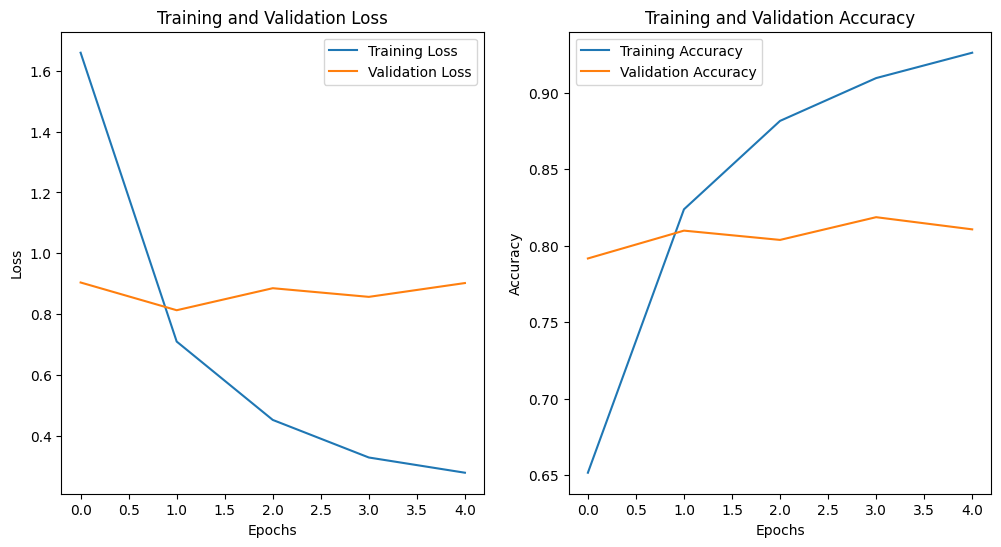

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Save the plots
plot_save_path = "/content/drive/MyDrive/training_validation_metrics.png"
plt.savefig(plot_save_path)
print(f"Plots saved to {plot_save_path}")

# Display the plots
plt.show()

In [ ]:
import os
from transformers import BertTokenizer
import tensorflow as tf
import joblib
import numpy as np

# Paths to the saved model, tokenizer, and label encoder
model_save_path = "/content/drive/MyDrive/bert_model"
tokenizer_save_path = "/content/drive/MyDrive/tokenizer"
label_encoder_path = "/content/drive/MyDrive/label_encoder.pkl"

# Load the saved model using TensorFlow
model = tf.saved_model.load(model_save_path)
print(f"Model loaded from {model_save_path}")

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
print(f"Tokenizer loaded from {tokenizer_save_path}")

# Load the saved label encoder
label_encoder = joblib.load(label_encoder_path)
print(f"Label encoder loaded from {label_encoder_path}")

# Example input text in Arabic
input_text = "التواضع رفعة، فمن تواضع لله رفعه."

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors='tf', padding='max_length', truncation=True, max_length=128)

# Make predictions
infer = model.signatures["serving_default"]
outputs = infer(input_ids=tf.constant(inputs['input_ids']),
               attention_mask=tf.constant(inputs['attention_mask']))

logits = outputs['dense'].numpy()

# Decode the predictions
predicted_label_index = np.argmax(logits, axis=-1)[0]
predicted_label = label_encoder.inverse_transform([predicted_label_index])

print(f"Predicted label index: {predicted_label_index}")
print(f"Predicted label: {predicted_label[0]}")

Model loaded from /content/drive/MyDrive/bert_model
Tokenizer loaded from /content/drive/MyDrive/tokenizer
Label encoder loaded from /content/drive/MyDrive/label_encoder.pkl
Predicted label index: 37
Predicted label: التواضع


In [ ]:
# Reload the Keras model from the SavedModel directory (if applicable)
from transformers import TFBertModel

# If `bert_model` was loaded as a SavedModel, wrap it in a Keras Model
inputs = {
    'input_ids': tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids"),
    'attention_mask': tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask"),
}

outputs = model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_ids'), name='input_ids', description="created by layer 'input_ids'"), an intermediate TF-Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. TF-Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom TF-Keras layer `call` and calling that layer on this symbolic input/output.

In [ ]:
# Evaluate the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
